## Part 2: Unsupervised Anomaly Detector (VAE)
**Project**: FraudGuard - Credit Card Fraud Detection 

**Goal**: Train VAE and Apply Conformal predicitons.

In [ ]:
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import classification_report

ROOT = Path.cwd().parent
sys.path.append(str(ROOT / "src"))

from fraudguard import conformal, datasets, seed,  metrics, viz

In [ ]:
1+1

In [ ]:
1+1

In [10]:
# Configs
CSV_PATH = Path.cwd().parent / "data" / "raw" / "creditcard.csv"
RANDOM_STATE = 42

# Global split: main/calib/test/val
MAIN_FRAC  = 0.70
CALIB_FRAC = 0.10
TEST_FRAC  = 0.20
VAE_VAL_FRAC = 0.20

# VAE hyperparams
BATCH_SIZE = 128
SCORE_BATCH_SIZE = 256
LR = 3e-4
WEIGHT_DECAY = 1e-5

PARAM_GRID = [
    {"latent_dim": 4,  "beta": 0.5, "hidden_layers": {"h1": 20, "h2": 15}},
    {"latent_dim": 8,  "beta": 0.5, "hidden_layers": {"h1": 32, "h2": 16}},
    {"latent_dim": 8,  "beta": 0.5, "hidden_layers": {"h1": 64, "h2": 32}},
    {"latent_dim": 16, "beta": 0.5, "hidden_layers": {"h1": 64, "h2": 32}},
]

EPOCHS = 30
PATIENCE = 10

OUT_DIR = ROOT / "docs" / "figures" / "figures_vae_conformal"
os.makedirs(OUT_DIR, exist_ok=True)
MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

seed.seed_everything(seed=RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


### Prepare data

In [11]:
splits = datasets.prepare_splits(
    mode="unsupervised", 
    csv_path=CSV_PATH,
    main_frac=MAIN_FRAC,
    calib_frac=CALIB_FRAC,
    test_frac=TEST_FRAC,
    val_frac=VAE_VAL_FRAC,
    random_state=RANDOM_STATE
    )

# VAE
X_train_vae_s = splits["X_train_vae_s"]
X_val_vae_s = splits["X_val_vae_s"]

# conformal
X_calib_legit_s = splits["X_calib_legit_s"]
y_calib = splits["y_calib"]

# test
X_test_s = splits["X_test_s"]
y_test = splits["y_test"]

Loaded: n=284807, fraud_rate=0.00173

Global splits:
  D_main : 199364 (fraud_rate=0.00173)
  D_calib: 28480 (fraud_rate=0.00172)
  D_test : 56963 (fraud_rate=0.00174)


In [12]:
#  load batches
train_loader = datasets.data_loader(X_train_vae_s, batch_size=BATCH_SIZE, shuffle=True)
val_loader = datasets.data_loader(X_val_vae_s, batch_size=BATCH_SIZE, shuffle=False)

### Train model

In [13]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, hidden_layers: dict, dropout_p: float = 0.2):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Vinay et al. style (for ~29 dims): input -> 20 -> 15 -> latent (symmetric decoder)
        h1 = hidden_layers["h1"]
        h2 = hidden_layers["h2"]

        # encoder
        self.enc_fc1 = nn.Linear(input_dim, h1)
        self.enc_bn1 = nn.BatchNorm1d(h1)
        self.enc_do1 = nn.Dropout(p=dropout_p)

        self.enc_fc2 = nn.Linear(h1, h2)
        self.enc_bn2 = nn.BatchNorm1d(h2)
        self.enc_do2 = nn.Dropout(p=dropout_p)

        self.fc_mu = nn.Linear(h2, latent_dim)
        self.fc_logvar = nn.Linear(h2, latent_dim)

        # decoder
        self.dec_fc1 = nn.Linear(latent_dim, h2)
        self.dec_bn1 = nn.BatchNorm1d(h2)

        self.dec_fc2 = nn.Linear(h2, h1)
        self.dec_bn2 = nn.BatchNorm1d(h1)

        self.dec_fc3 = nn.Linear(h1, input_dim)

    def encode(self, x):
        h = F.relu(self.enc_bn1(self.enc_fc1(x)))
        h = self.enc_do1(h)
        h = F.relu(self.enc_bn2(self.enc_fc2(h)))
        h = self.enc_do2(h)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.dec_bn1(self.dec_fc1(z)))
        h = F.relu(self.dec_bn2(self.dec_fc2(h)))
        return self.dec_fc3(h)  # linear for standardized continuous features

    def forward(self, x, deterministic: bool = False):
        mu, logvar = self.encode(x)
        z = mu if deterministic else self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


def vae_loss(recon, x, mu, logvar, beta=1.0):
    recon_loss = ((recon - x) ** 2).mean(dim=1).mean()  # per-sample mse -> mean
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total = recon_loss + beta * kl
    return total, recon_loss, kl


def eval_epoch(model, loader, beta=1.0):
    with torch.no_grad():
        model.eval()
        tot, rec, klv, n = 0.0, 0.0, 0.0, 0
        for x in loader:
            x = x.to(device)
            recon, mu, logvar = model(x, deterministic=True)
            loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta)
            bs = x.size(0)
            tot += loss.item() * bs
            rec += rloss.item() * bs
            klv += kl.item() * bs
            n += bs
    return tot / n, rec / n, klv / n

In [14]:
def train_vae(model, train_loader, val_loader, epochs, lr, weight_decay, patience, beta=1.0):
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_total": [], "train_recon": [], "train_kl": [],
        "val_total": [], "val_recon": [], "val_kl": []
    }

    best_val_recon = float("inf")
    best_val_total = float("inf")
    best_state = None
    best_epoch = -1
    bad_epochs = 0

    warmup_epochs = 10  # KL warmup

    for epoch in tqdm(range(1, epochs + 1), desc="epochs", leave=True):
        model.train()
        tot, rec, klv, n = 0.0, 0.0, 0.0, 0

        beta_t = beta * min(1.0, epoch / warmup_epochs)

        for x in train_loader:
            x = x.to(device)
            optim.zero_grad(set_to_none=True)

            recon, mu, logvar = model(x)
            loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta_t)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # clipping grad
            optim.step()

            bs = x.size(0)
            tot += loss.item() * bs
            rec += rloss.item() * bs
            klv += kl.item() * bs
            n += bs

        train_total = tot / n
        train_recon = rec / n
        train_kl = klv / n

        val_total, val_recon, val_kl = eval_epoch(model, val_loader, beta)

        history["train_total"].append(train_total)
        history["train_recon"].append(train_recon)
        history["train_kl"].append(train_kl)
        history["val_total"].append(val_total)
        history["val_recon"].append(val_recon)
        history["val_kl"].append(val_kl)
        
        if epoch == 1 or epoch % 3 == 0 or epoch == epochs:
            print(
                f"epoch {epoch:03d} | "
                f"train total={train_total:.3f} recon={train_recon:.3f} kl={train_kl:.3f} | "
                f"val total={val_total:.3f} recon={val_recon:.3f} kl={val_kl:.3f}"
            )

        # Early stopping criterion for grid search:
        # prioritize val_recon (since anomaly score uses recon MSE), tie-break with val_total
        improved = (val_recon < best_val_recon - 1e-7) or (
            abs(val_recon - best_val_recon) <= 1e-7 and val_total < best_val_total - 1e-7
        )
        if improved:
            best_val_recon = val_recon
            best_val_total = val_total
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch} (val_recon={best_val_recon:.3f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history, best_epoch, best_val_recon, best_val_total

In [15]:
# Grid search
input_dim = X_train_vae_s.shape[1]
best = None  # will store dict with model + params + stats
all_summeries = []

for i, cfg in enumerate(PARAM_GRID, start=1):
    seed.seed_everything(RANDOM_STATE + i)  # stable but different init per config
    latent_dim = cfg["latent_dim"]
    beta = cfg["beta"]
    hidden_layers = cfg["hidden_layers"]

    print(f"\n--- Config {i}/{len(PARAM_GRID)}: latent_dim={latent_dim}, hidden_layers={hidden_layers},  beta={beta} ---") 
    model = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_layers=hidden_layers).to(device)

    hist, be, val_recon_best, val_total_best = train_vae(
        model, train_loader, val_loader,
        beta=beta, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE
    )

    summary = {
        "cfg": cfg,
        "model_state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
        "history": hist,
        "best_epoch": be,
        "best_val_recon": val_recon_best,
        "best_val_total": val_total_best,
    }
    
    all_summeries.append(summary)

    if best is None:
        best = summary
    else:
        # choose best by val_recon, tie-break with val_total
        improved = (summary["best_val_recon"] < best["best_val_recon"] - 1e-7) or (
            abs(summary["best_val_recon"] - best["best_val_recon"]) <= 1e-7 and
            summary["best_val_total"] < best["best_val_total"] - 1e-7
        )
        if improved:
            best = summary

print("\n====================")
print("Best config selected\n")
print(f"  latent_dim={best['cfg']['latent_dim']}, beta={best['cfg']['beta']}, hidden_layers={best["cfg"]["hidden_layers"]}")
print(f"  best_epoch={best['best_epoch']}")
print(f"  best_val_recon={best['best_val_recon']:.3f}")
print(f"  best_val_total={best['best_val_total']:.3f}")

# Restore best model
vae = VAE(input_dim=input_dim, latent_dim=best["cfg"]["latent_dim"], hidden_layers=best["cfg"]["hidden_layers"]).to(device)
vae.load_state_dict(best["model_state"])
history = best["history"]
BETA = best["cfg"]["beta"]


--- Config 1/4: latent_dim=4, hidden_layers={'h1': 20, 'h2': 15},  beta=0.5 ---


epochs:   3%|▎         | 1/30 [00:13<06:17, 13.02s/it]

epoch 001 | train total=0.997 recon=0.986 kl=0.220 | val total=1.075 recon=0.927 kl=0.296


epochs:  10%|█         | 3/30 [00:40<06:06, 13.59s/it]

epoch 003 | train total=0.952 recon=0.910 kl=0.284 | val total=1.012 recon=0.872 kl=0.280


epochs:  20%|██        | 6/30 [01:15<04:51, 12.16s/it]

epoch 006 | train total=0.960 recon=0.912 kl=0.159 | val total=0.954 recon=0.867 kl=0.173


epochs:  30%|███       | 9/30 [01:49<04:05, 11.68s/it]

epoch 009 | train total=0.962 recon=0.921 kl=0.092 | val total=0.964 recon=0.903 kl=0.121


epochs:  40%|████      | 12/30 [02:24<03:27, 11.55s/it]

epoch 012 | train total=0.954 recon=0.920 kl=0.069 | val total=0.961 recon=0.919 kl=0.084


epochs:  50%|█████     | 15/30 [03:01<03:05, 12.37s/it]

epoch 015 | train total=0.949 recon=0.917 kl=0.066 | val total=1.007 recon=0.964 kl=0.086


epochs:  50%|█████     | 15/30 [03:15<03:15, 13.02s/it]


Early stopping at epoch 16. Best epoch: 6 (val_recon=0.867)

--- Config 2/4: latent_dim=8, hidden_layers={'h1': 32, 'h2': 16},  beta=0.5 ---


epochs:   3%|▎         | 1/30 [00:12<06:12, 12.84s/it]

epoch 001 | train total=0.977 recon=0.963 kl=0.286 | val total=1.062 recon=0.851 kl=0.422


epochs:  10%|█         | 3/30 [00:42<06:27, 14.35s/it]

epoch 003 | train total=0.884 recon=0.822 kl=0.412 | val total=0.926 recon=0.736 kl=0.380


epochs:  20%|██        | 6/30 [01:19<05:09, 12.89s/it]

epoch 006 | train total=0.888 recon=0.804 kl=0.282 | val total=0.849 recon=0.711 kl=0.274


epochs:  30%|███       | 9/30 [01:54<04:15, 12.15s/it]

epoch 009 | train total=0.903 recon=0.814 kl=0.198 | val total=0.834 recon=0.738 kl=0.192


epochs:  40%|████      | 12/30 [02:28<03:26, 11.47s/it]

epoch 012 | train total=0.901 recon=0.818 kl=0.166 | val total=0.829 recon=0.745 kl=0.168


epochs:  50%|█████     | 15/30 [03:05<03:01, 12.10s/it]

epoch 015 | train total=0.894 recon=0.812 kl=0.163 | val total=0.827 recon=0.738 kl=0.177


epochs:  50%|█████     | 15/30 [03:17<03:17, 13.18s/it]


Early stopping at epoch 16. Best epoch: 6 (val_recon=0.711)

--- Config 3/4: latent_dim=8, hidden_layers={'h1': 64, 'h2': 32},  beta=0.5 ---


epochs:   3%|▎         | 1/30 [00:12<06:03, 12.54s/it]

epoch 001 | train total=0.916 recon=0.892 kl=0.493 | val total=1.069 recon=0.687 kl=0.765


epochs:  10%|█         | 3/30 [00:37<05:42, 12.69s/it]

epoch 003 | train total=0.779 recon=0.666 kl=0.752 | val total=0.885 recon=0.512 kl=0.744


epochs:  20%|██        | 6/30 [01:18<05:14, 13.11s/it]

epoch 006 | train total=0.819 recon=0.669 kl=0.501 | val total=0.751 recon=0.530 kl=0.442


epochs:  30%|███       | 9/30 [01:54<04:18, 12.32s/it]

epoch 009 | train total=0.856 recon=0.705 kl=0.335 | val total=0.738 recon=0.578 kl=0.321


epochs:  40%|████      | 12/30 [02:27<03:25, 11.44s/it]

epoch 012 | train total=0.857 recon=0.721 kl=0.272 | val total=0.745 recon=0.613 kl=0.264


epochs:  47%|████▋     | 14/30 [03:02<03:28, 13.00s/it]


epoch 015 | train total=0.849 recon=0.719 kl=0.261 | val total=0.753 recon=0.627 kl=0.253
Early stopping at epoch 15. Best epoch: 5 (val_recon=0.507)

--- Config 4/4: latent_dim=16, hidden_layers={'h1': 64, 'h2': 32},  beta=0.5 ---


epochs:   3%|▎         | 1/30 [00:13<06:25, 13.30s/it]

epoch 001 | train total=0.879 recon=0.854 kl=0.489 | val total=1.014 recon=0.613 kl=0.802


epochs:  10%|█         | 3/30 [00:36<05:24, 12.01s/it]

epoch 003 | train total=0.714 recon=0.614 kl=0.661 | val total=0.747 recon=0.442 kl=0.610


epochs:  20%|██        | 6/30 [01:12<04:46, 11.96s/it]

epoch 006 | train total=0.725 recon=0.586 kl=0.464 | val total=0.622 recon=0.413 kl=0.419


epochs:  30%|███       | 9/30 [01:47<04:08, 11.81s/it]

epoch 009 | train total=0.760 recon=0.602 kl=0.350 | val total=0.601 recon=0.456 kl=0.291


epochs:  40%|████      | 12/30 [02:21<03:25, 11.43s/it]

epoch 012 | train total=0.762 recon=0.604 kl=0.316 | val total=0.590 recon=0.448 kl=0.283


epochs:  50%|█████     | 15/30 [02:54<02:47, 11.15s/it]

epoch 015 | train total=0.754 recon=0.598 kl=0.314 | val total=0.589 recon=0.452 kl=0.274


epochs:  50%|█████     | 15/30 [03:05<03:05, 12.38s/it]

Early stopping at epoch 16. Best epoch: 6 (val_recon=0.413)

Best config selected

  latent_dim=16, beta=0.5, hidden_layers={'h1': 64, 'h2': 32}
  best_epoch=6
  best_val_recon=0.413
  best_val_total=0.622


Saved: outputs_vae_conformal\vae_losses_best.png


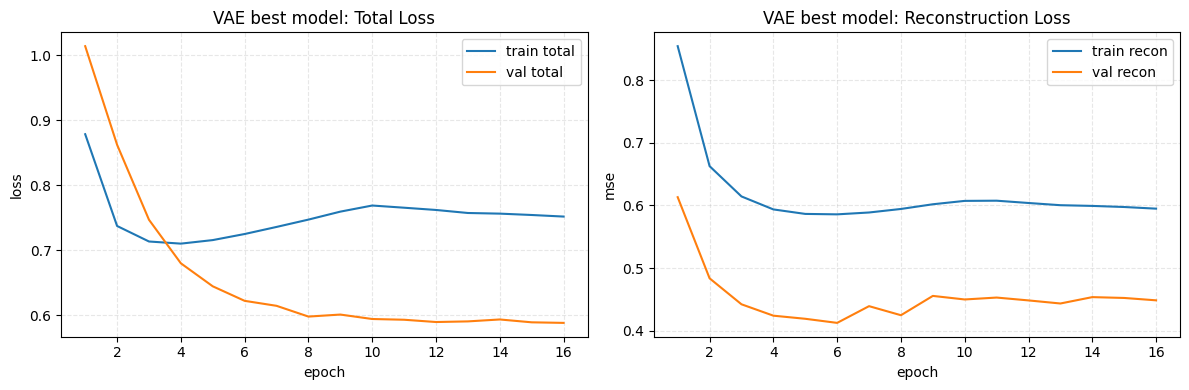

Saved: outputs_vae_conformal\vae_losses_smallest.png


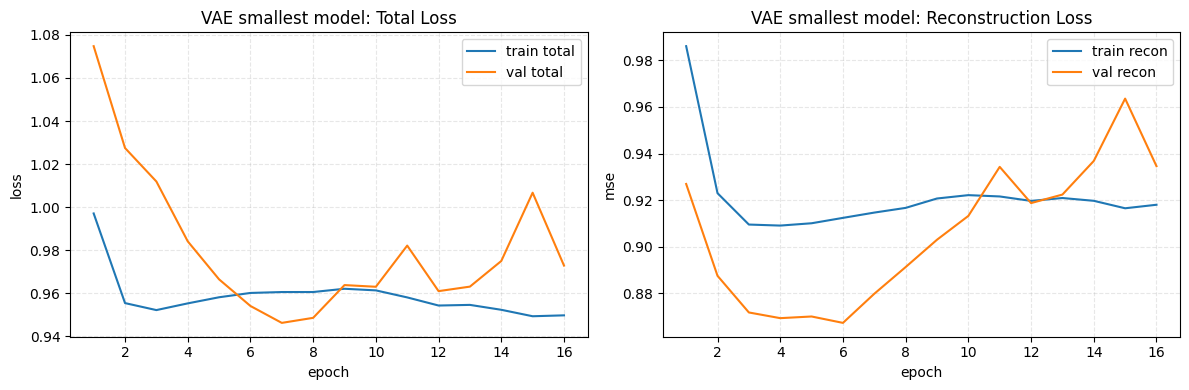

In [16]:
def plot_vae_losses(history, title_prefix="VAE", out_dir=None, save_name=None, show=True):
    """
    Plots VAE total loss + reconstruction loss side-by-side.
    
    history: dict with keys
        - "train_total", "val_total", "train_recon", "val_recon"
    title_prefix: str (optional title prefix)
    out_dir: str (optional save directory)
    save_name: str (optional file name to save, e.g. "vae_losses.png")
    show: bool (display figure if True)
    """
    epochs = np.arange(1, len(history["train_total"]) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Total Loss
    axs[0].plot(epochs, history["train_total"], label="train total")
    axs[0].plot(epochs, history["val_total"], label="val total")
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("loss")
    axs[0].set_title(f"{title_prefix}: Total Loss")
    axs[0].legend()
    axs[0].grid(True, linestyle="--", alpha=0.3)

    # Recon Loss
    axs[1].plot(epochs, history["train_recon"], label="train recon")
    axs[1].plot(epochs, history["val_recon"], label="val recon")
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("mse")
    axs[1].set_title(f"{title_prefix}: Reconstruction Loss")
    axs[1].legend()
    axs[1].grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()

    # Saving logic (optional)
    if out_dir is not None and save_name is not None:
        os.makedirs(out_dir, exist_ok=True)
        save_path = os.path.join(out_dir, save_name)
        fig.savefig(save_path, dpi=200)
        print(f"Saved: {save_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

plot_vae_losses(history, title_prefix="VAE best model", out_dir=OUT_DIR, save_name="vae_losses_best.png")
plot_vae_losses(all_summeries[0]["history"], title_prefix="VAE smallest model", out_dir=OUT_DIR, save_name="vae_losses_smallest.png")

In [ ]:
# Save best model

SAVE_PATH = MODELS_DIR / "vae_best_weights.pt"
torch.save(best["model_state"], SAVE_PATH)

# open best model
#input_dim = X_train_vae_s.shape[1]
#vae = VAE(input_dim=input_dim, latent_dim=16, hidden_layers={'h1': 64, 'h2': 32})
#vae.load_state_dict(torch.load(SAVE_PATH, map_location="cpu"))
#vae.eval()

## Conformal predictions

In [18]:
def vae_scores_mse(model, X_np, batch_size=SCORE_BATCH_SIZE):
    with torch.no_grad():
        """Return per-sample reconstruction MSE scores."""
        model.eval()
        X_loaded = datasets.data_loader(X_np, batch_size=batch_size, shuffle=False)
        scores = []
        for x in X_loaded:
            x = x.to(device)
            recon, _, _ = model(x, deterministic=True)
            s = ((x - recon) ** 2).mean(dim=1)
            scores.append(s.detach().cpu().numpy())
    return np.concatenate(scores, axis=0)

In [19]:
# scores on CLEAN calibration set (legit only)
scores_calib_legit = vae_scores_mse(vae, X_calib_legit_s) 

scores_test = vae_scores_mse(vae, X_test_s)

alphas = [0.001, 0.01, 0.05, 0.1]
taus = {a: conformal.conformal_outlier_threshold(scores_calib_legit, a) for a in alphas}

print("Conformal outlier thresholds (calibrated on CLEAN legit only):")
for a in alphas:
    print(f"  alpha={a:.2%} -> qhat={taus[a]:.6f}")

print("\nTest performance at conformal thresholds:")
for a in alphas:
    tau = taus[a]
    fpr_hat, tpr_hat, tn, fp, fn, tp = conformal.confusion_from_scores(y_test, scores_test, tau)
    print(
        f"  alpha={a:.2%} | qhat={tau:.6f} | "
        f"FPR(test)={fpr_hat:.4%} | TPR(test)={tpr_hat:.4%} | "
        f"TN={tn} FP={fp} FN={fn} TP={tp}"
    )

Conformal outlier thresholds (calibrated on CLEAN legit only):
  alpha=0.10% -> qhat=5.606868
  alpha=1.00% -> qhat=1.608544
  alpha=5.00% -> qhat=0.925417
  alpha=10.00% -> qhat=0.707722

Test performance at conformal thresholds:
  alpha=0.10% | qhat=5.606868 | FPR(test)=0.1055% | TPR(test)=55.5556% | TN=56804 FP=60 FN=44 TP=55
  alpha=1.00% | qhat=1.608544 | FPR(test)=0.9830% | TPR(test)=79.7980% | TN=56305 FP=559 FN=20 TP=79
  alpha=5.00% | qhat=0.925417 | FPR(test)=4.7939% | TPR(test)=81.8182% | TN=54138 FP=2726 FN=18 TP=81
  alpha=10.00% | qhat=0.707722 | FPR(test)=9.5385% | TPR(test)=83.8384% | TN=51440 FP=5424 FN=16 TP=83


## Plots

In [26]:
# confusion matrix
best_f1_threshold, f1, _, _, _ = metrics.find_best_threshold_by_f1(y_test, scores_test)
print(f"best_f1_threshold: {best_f1_threshold:.3f}")
y_pred = (scores_test > best_f1_threshold).astype(int)
print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))

best_f1_threshold: 4.119
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.44      0.69      0.54        99

    accuracy                           1.00     56963
   macro avg       0.72      0.84      0.77     56963
weighted avg       1.00      1.00      1.00     56963



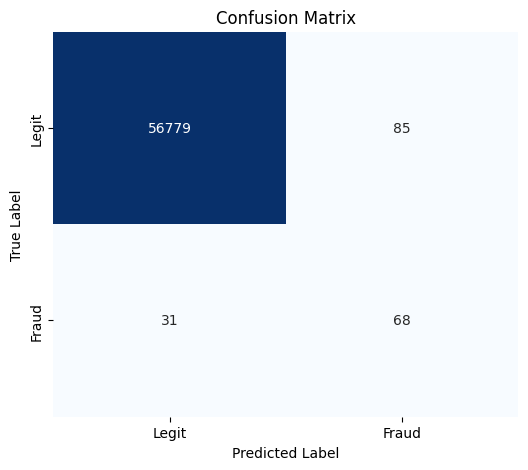

In [ ]:
viz.plot_confusion_matrix(
    y_test,
    y_pred,
    title="Confusion Matrix",
    title_prefix="vae_",
    save_path=str(ROOT / "docs" / "figures" / "figures_vae_conformal")
)

In [27]:
viz.plot_roc_pr_with_conformal_points(
    y_true=y_test,
    scores=scores_test,
    taus_by_alpha=taus,
    best_f1_tau=best_f1_threshold, 
    f1=np.round(f1,3),
    title_prefix="VAE – ",
    save_path=str(ROOT / "docs" / "figures" / "figures_vae_conformal")
)


TypeError: plot_roc_pr_with_conformal_points() got an unexpected keyword argument 'save_dir'